In [1]:
from lxml import html
import requests
import re
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('fivethirtyeight')

%matplotlib inline
from __future__ import division

import ast

In [3]:
url = 'http://www.whoscored.com/Teams/65/Fixtures/Spain-Barcelona'
# url = 'http://docs.python-guide.org/en/latest/scenarios/scrape/'
page = requests.get(url)
tree = html.fromstring(page.text)
team_fixture = tree.xpath('//*[@id="layout-content-wrapper"]/div[1]/script[3]')

In [4]:
#  q = re.search(re.escape("DataStore.prime('teamfixtures', $.extend({ teamId: 65 }, parametersCopy), ")
#               + '(\[.*\])' + re.escape(");"), 
#          team_fixture[0].text)

s = "DataStore\.prime\('teamfixtures', \$\.extend\({ teamId: 65 }, parametersCopy\),\ "

q2 = re.search(s, team_fixture[0].text, re.DOTALL)
# print q2.group()
fixtures =  re.split(s, team_fixture[0].text)[1].split(";")[0]
fixtures = fixtures.replace(')', '')
fixtures = fixtures[1:-2]

In [6]:
fixtures_list = [_x.lstrip(',') for _x in fixtures.splitlines()]
fixtures_list = ','.join(fixtures_list)
fixtures_list = ast.literal_eval(fixtures_list)

# ,[885739,1,'21-10-2014','19:45',65,'Barcelona',0,130,'Ajax',0,'3 : 1','2 : 0',1,1,'FT','2014/2015','UEFA Champions League','1',12,250,4333,11510,'ICL','es','nl',1,1,0]
df = pd.DataFrame(np.array(fixtures_list),
                    columns=['matchId', 'unknownId0', 'matchDate', 'kickoffTime', 'homeTeamId', 'homeTeam', 'hTRed', 'awayTeamId', 'awayTeam',
                            'aTRed', 'scoreFT', 'scoreHT', 'didBarcaStore', 'unknownId2', 'FTorETAorPen', 'seasonId', 'cupName', '1x2Bet', 'cupIdInRegion', 'regionId', 'seasonId', 'stageId', 'abbr', 'homeCountry', 'awayCountry',
                            'isEuropeanGame', 'isDomesticCup', 'hasMatchReportForCup'])


df['matchDate'] = pd.to_datetime(df['matchDate'], format='%d-%m-%Y')
# df['kickoffTime'] = pd.to_datetime(df['kickoffTime'], format='%H:%M')
df.convert_objects(convert_numeric=True).dtypes



# for _x in range(0,7):
#     del df['unknownId'+str(_x)]
del df['FTorETAorPen']
del df['seasonId']
del df['cupIdInRegion']
# del df['seasonId']
del df['stageId']
# del df['homeTeamId']
# del df['awayTeamId']

from IPython.display import HTML
HTML(df.to_html())

,matchId,unknownId0,matchDate,kickoffTime,homeTeamId,homeTeam,hTRed,awayTeamId,awayTeam,aTRed,scoreFT,scoreHT,didBarcaStore,unknownId2,cupName,1x2Bet,regionId,abbr,homeCountry,awayCountry,isEuropeanGame,isDomesticCup,hasMatchReportForCup
0,862059,1,2014-08-24,20:00,65,Barcelona,1,833,Elche,0,3 : 0,1 : 0,1,1,La Liga,1,206,SLL,es,es,0,1,0
1,862070,1,2014-08-31,18:00,839,Villarreal,0,65,Barcelona,0,0 : 1,0 : 0,1,1,La Liga,2,206,SLL,es,es,0,1,0
2,862080,1,2014-09-13,15:00,65,Barcelona,0,53,Athletic Club,0,2 : 0,0 : 0,1,1,La Liga,1,206,SLL,es,es,0,1,0
3,885734,1,2014-09-17,19:45,65,Barcelona,0,692,APOEL Nicosia,0,1 : 0,1 : 0,1,1,UEFA Champions League,1,250,ICL,es,cy,1,1,0
4,862110,1,2014-09-21,20:00,832,Levante,1,65,Barcelona,0,0 : 5,0 : 2,1,1,La Liga,2,206,SLL,es,es,0,1,0
5,862097,1,2014-09-24,21:00,69,Malaga,0,65,Barcelona,0,0 : 0,0 : 0,0,1,La Liga,0,206,SLL,es,es,0,1,0
6,862195,1,2014-09-27,17:00,65,Barcelona,0,925,Granada,0,6 : 0,3 : 0,1,1,La Liga,1,206,SLL,es,es,0,1,0
7,885736,1,2014-09-30,19:45,304,Paris Saint Germain,0,65,Barcelona,0,3 : 2,2 : 1,1,1,UEFA Champions League,1,250,ICL,fr,es,1,1,0
8,862147,1,2014-10-04,17:00,64,Rayo Vallecano,2,65,Barcelona,0,0 : 2,0 : 2,1,1,La Liga,2,206,SLL,es,es,0,1,0
9,862177,1,2014-10-18,19:00,65,Barcelona,0,824,Eibar,0,3 : 0,0 : 0,1,1,La Liga,1,206,SLL,es,es,0,1,0


In [34]:
home_goals = 0
away_goals = 0
total_goals = 0
barca_goals = []
team_goal = []

for i in df.index:
    m = re.match(r"\*?(\d)\s:\s(\d)\*?", df.ix[i]['scoreFT'])
    if df.ix[i]['homeTeamId'] == '65':
        home_goals += int(m.group(1))
        barca_goals.append(int(m.group(1)))
    else:
        away_goals += int(m.group(2))
        barca_goals.append(int(m.group(2)))
        
        
total_goals = home_goals + away_goals
print (barca_goals)

print total_goals, home_goals+3, away_goals-3

[3, 1, 2, 1, 5, 0, 6, 2, 2, 3, 3, 1, 0, 2, 2, 5, 4, 1, 4, 5, 3, 0, 8, 5, 0, 5, 3, 4, 4, 1, 6, 3, 3, 5, 3, 5, 0, 2, 3, 3, 6, 2, 1, 2, 1, 4, 2, 3, 2, 2, 2, 6, 8, 3, 2, 2, 1, 2, 3, 3]
175 97 78


In [8]:
df['BarcaGoals'] = barca_goals

matchId                         object
unknownId0                      object
matchDate               datetime64[ns]
kickoffTime                     object
homeTeamId                      object
homeTeam                        object
hTRed                           object
awayTeamId                      object
awayTeam                        object
aTRed                           object
scoreFT                         object
scoreHT                         object
didBarcaStore                   object
unknownId2                      object
cupName                         object
1x2Bet                          object
regionId                        object
abbr                            object
homeCountry                     object
awayCountry                     object
isEuropeanGame                  object
isDomesticCup                   object
hasMatchReportForCup            object
BarcaGoals                       int64
dtype: object

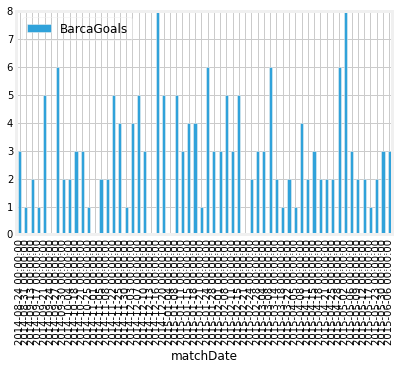

In [19]:
# df.plot(x='matchDate', y='BarcaGoals', kind='bar')
# df.dtypes

In [10]:
g = df.groupby(df['matchDate'].map(lambda x: '{}-{:02d}'.format(x.year, x.month)))

In [26]:
df2 = pd.DataFrame(g['BarcaGoals'].sum())
df2 = df2.rename(columns = {'matchDate': 'Month', 'BarcaGoals': 'Goals'})
df2.index = df2.index.rename('Month')
# df2.index = pd.to_datetime(df2.index, format='%Y-%m')
df2.index = pd.to_datetime(df2.index, format='%Y-%m')

DatetimeIndex(['2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01',
               '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01',
               '2015-04-01', '2015-05-01', '2015-06-01'],
              dtype='datetime64[ns]', freq=None, tz=None)

In [32]:
month_array = df['matchDate'].map(lambda x: x.month).values

# count element occurences in np.array
def unique_count(a):
    unique, inverse = np.unique(a, return_inverse=True)
    count = np.zeros(len(unique), np.int)
    np.add.at(count, inverse, 1)
    return np.vstack((unique, count)).T


# unique_count(month_array)[:,1]

# from collections import Counter
# c = Counter([i for j in month_array for i in j])

## 各月进球数

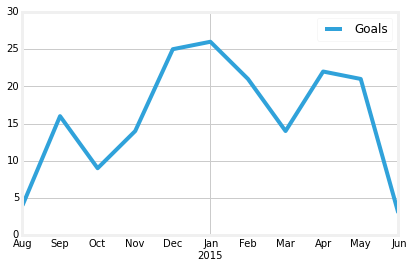

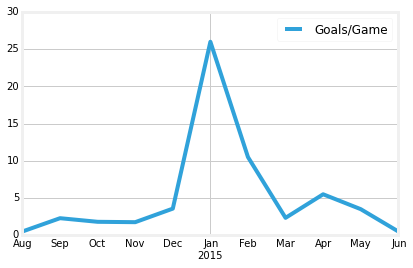

In [31]:
df2['Games'] = unique_count(month_array)[:,1]
df2['Goals/Game'] = df2['Goals'] / df2['Games']
df2.plot(x=df2.index.to_datetime(), y='Goals')
df2.plot(x=df2.index.to_datetime(), y='Goals/Game')
# plt.gcf().autofmt_xdate()

In [35]:
# fig, ax = plt.subplots()
# ax.plot(df2.index.to_datetime(), df2.Goals)
# # ax.set_xticklabels([dt.strftime('%Y-%m') for dt in df2.index.to_datetime()])
# fig.autofmt_xdate()


In [37]:
s = pd.Series(barca_goals)

In [46]:
s.value_counts()[1]

8

In [56]:
df3 = pd.DataFrame(s.value_counts())
df3

,0
2,15
3,14
1,8
5,7
4,5
0,5
6,4
8,2


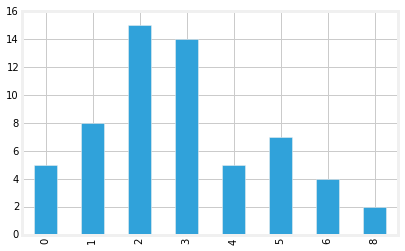

In [64]:
df3 = df3.sort_index()
df3.plot(kind='bar', legend=False)

In [ ]:
page.text